In [1]:
#!/usr/bin/python3
# coding: utf-8
# Hokkaido

In [2]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib
import sys
if "ipy" not in sys.argv[0]:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import os
import pandas as pd
from PIL import Image
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed, json2nparr, code2int, age2int, \
    get_populations, get_os_idx_of_arr, dump_val_in_arr, \
    calc_last1w2w_dif, create_basic_scatter_figure, \
    mak_japan_heatmap
from hokkaidomap import sub_prefs, get_sub_code, make_hokkaido_heatmap

In [3]:
# 北海道 OpenData を参照する
# https://www.harp.lg.jp/opendata/dataset/1369.html
# 北海道は面積が広いため、振興局別に集計を行う
base_uri = "https://www.harp.lg.jp/opendata/dataset/1369/resource/3132/"
patients_file = "010006_hokkaido_covid19_patients.csv"
download_if_needed(base_uri, patients_file)
base_uri = "https://www.harp.lg.jp/opendata/dataset/1369/resource/2853/"
data_file = "covid19_data.csv"
download_if_needed(base_uri, data_file)

In [4]:
patients = []
# CSVデータを整形する
with codecs.open(patients_file, encoding="shift-jis") as f:
    l = f.readline() # 先頭行をスキップ
    while l:
        l = f.readline().replace("\r\n", "")
        arr = l.split(',')
        if len(arr) == 16:
            patients.append(
                [
                    code2int(arr[0]), # No
                    get_sub_code(arr[6]), # sub-pref code
                    arr[6], # sub-pref
                    dt.strptime(arr[4], "%Y-%m-%d"), # press date
                    arr[5], # infected 
                    arr[7], # Age
                    arr[8], # Sex
                ]
            )

print("Total: {}".format(len(patients)))

Total: 2323


In [5]:
# Pandas DataFrame を作成する
df = pd.DataFrame(patients, columns=['No', 'Code', 'State', 'Date', 'DoW', 'Age', 'Sex'])

In [6]:
# Daily の新規感染者を集計する
daily_new = df.groupby('Date').size()
print("Daily New: {}".format(daily_new[-1]))
# duration
frm_date = daily_new.index[0]
end_date = daily_new.index[-1]
print("From: {} To: {}".format(frm_date, end_date))
# moving average by week
ave_mov_days = 7
# 移動平均を算出する
mov_mean = daily_new.rolling(ave_mov_days).mean()

Daily New: 27
From: 2020-01-28 00:00:00 To: 2020-10-09 00:00:00


In [7]:
# 4 weeks later
xbins = daily_new.index.tolist()
days2pred = 2 * ave_mov_days # 2 weeks
# 2週間先の日付列を取得する
two_weeks_later = pd.date_range(xbins[-1] + td(days=1), xbins[-1] + td(days=days2pred)).to_pydatetime()
xbins_pred = xbins.copy()
xbins_pred.extend(two_weeks_later)

X = np.arange(0, len(daily_new.index.values))[:, np.newaxis]
X_pred = np.arange(0, len(xbins_pred))[:, np.newaxis]
y_gpr = get_gpr_predict(X, daily_new.values, X_pred, 80, 10, 200)

y 0 val = 27.


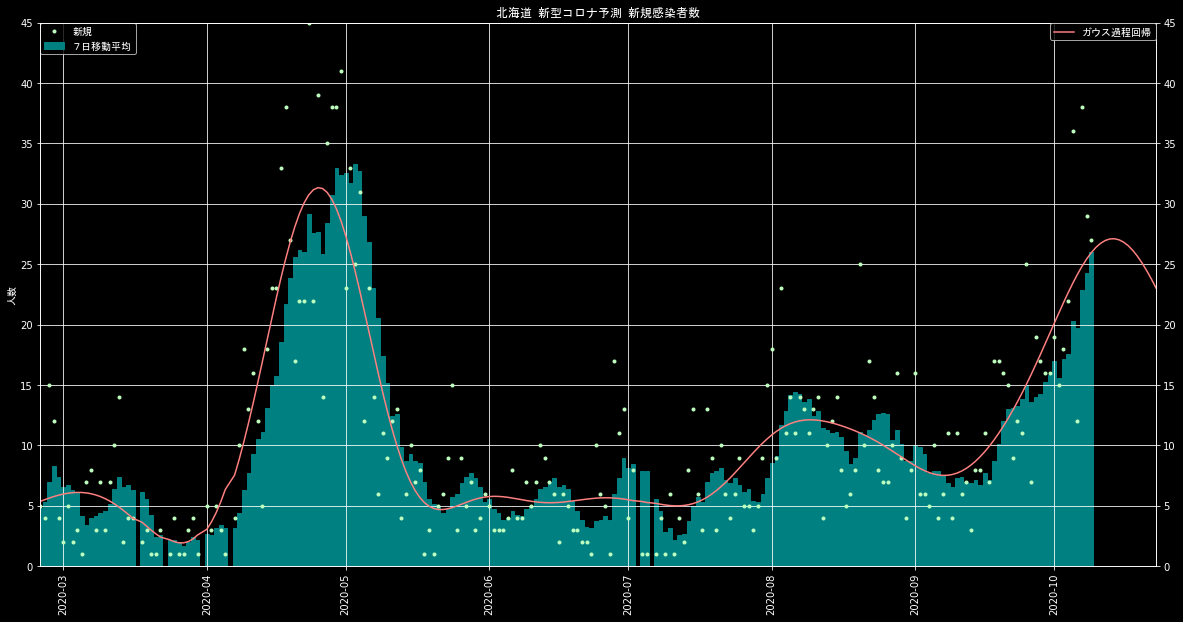

In [8]:
fig, ax = create_basic_plot_figure()
ymax = max(daily_new)
plt.title('北海道 新型コロナ予測 新規感染者数', fontname=FONT_NAME)
plt.xlim(xbins_pred[ave_mov_days], xbins_pred[-1])
plt.ylim(0, ymax)
plt.plot(xbins, daily_new,  '.', linewidth=1, color='#c0ffc0')
plt.bar(xbins, mov_mean, color='#008080', edgecolor='#008080', alpha=1)
plt.legend(labels=["新規", "７日移動平均"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
ax2 = ax.twinx()
plt.plot(xbins_pred, y_gpr, '-', linewidth=1.5, color='#ff8080')
plt.ylim(0, ymax)
plt.legend(labels=["ガウス過程回帰"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
show_and_clear(fig, "docs/images/hokkaido.jpg")

In [9]:
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body = "北海道 新型コロナ予測 新規感染者数(北海道 " + today_str + " 時点)"
tw = get_twitter()
tweet_with_image(tw, "docs/images/hokkaido.jpg", tw_body)

In [10]:
cov19data = []
# CSVデータを整形する
with codecs.open(data_file, encoding="shift-jis") as f:
    l = f.readline() # 先頭行をスキップ
    while l:
        l = f.readline().replace("\r\n", "")
        arr = l.split(',')
        if len(arr) == 23:
            cov19data.append(
                [
                    dt(int(arr[1]), int(arr[2]), int(arr[3])), # date
                    blank2zero(arr[4]), # tests
                    blank2zero(arr[6]), # positive
                    blank2zero(arr[19]) # postive rate [%]
                ]
            )

print("Total: {}".format(len(cov19data)))

Total: 256


In [11]:
pos_rate_np = np.array(cov19data)
#print("{}".format(pos_rate_np))

In [12]:
xbins = pos_rate_np[:, 0]
two_weeks_later = pd.date_range(xbins[-1] + td(days=1), xbins[-1] + td(days=days2pred)).to_pydatetime()
xbins_pred = xbins.tolist()
xbins_pred.extend(two_weeks_later)
X = np.arange(0, len(pos_rate_np[:, 0]))[:, np.newaxis]
X_pred = np.arange(0, len(xbins_pred))[:, np.newaxis]

y_test = get_gpr_predict(X, pos_rate_np[:, 1], X_pred)
y_rate = get_gpr_predict(X, pos_rate_np[:, 3], X_pred)

y 0 val = 740.
y 0 val = 3.7.


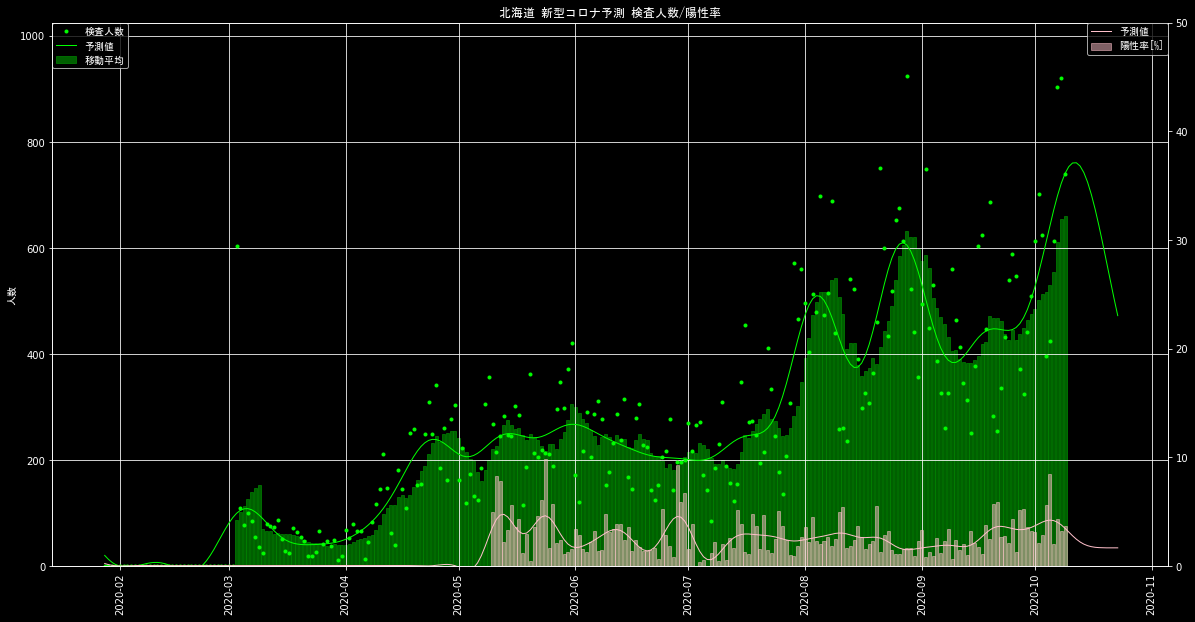

In [13]:
fig, ax = create_basic_plot_figure()
plt.title('北海道 新型コロナ予測 検査人数/陽性率', fontname=FONT_NAME)
plt.ylabel('人数', fontname=FONT_NAME)
plt.ylim(0, max(pos_rate_np[:, 1])+100)
plt.plot(xbins, pos_rate_np[:, 1], '.', linewidth=1.5, color='#00ff00')
plt.plot(xbins_pred, y_test, '-', color='#00ff00', linewidth=1)
plt.bar(xbins, moving_average(pos_rate_np[:, 1]), color='#008000', edgecolor='#008000', alpha=.75)
plt.legend(labels=["検査人数", "予測値", "移動平均"], loc='upper left', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
ax2 = ax.twinx()
plt.ylim(0, 50)
ax2.plot(xbins_pred, y_rate, '-', color='pink', linewidth=1)
ax2.bar(xbins, pos_rate_np[:, 3], color='pink', edgecolor='pink', alpha=.5)
plt.legend(labels=["予測値", "陽性率[%]"], loc='upper right', borderaxespad=0, fontsize=12, prop={"family":FONT_NAME})
show_and_clear(fig, "docs/images/hokkaido-rate.jpg")

In [14]:
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body = "北海道 新型コロナ予測 検査人数/陽性率(北海道 " + today_str + " 時点)"
tweet_with_image(tw, "docs/images/hokkaido-rate.jpg", tw_body)

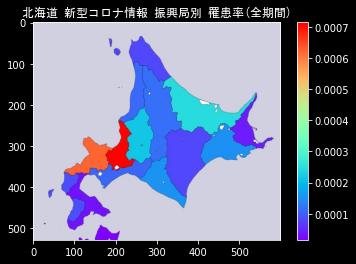

In [15]:
# 振興局別感染者数
sub_poss = df.groupby('Code').size()
#print("Sub-pref Pos: {}".format(sub_poss))
vals = []
for k, v in sub_prefs.items():
    vals.append(sub_poss.values[k] / v['total'])
#print(vals)
make_hokkaido_heatmap(
    "docs/images/hokkaido-all.jpg",
    "北海道 新型コロナ情報 振興局別 罹患率(全期間)",
    vals)

In [16]:
tw_body = "北海道 新型コロナ情報 振興局別 罹患率[全期間] (北海道 " + today_str + " 時点)"
tweet_with_image(tw, "docs/images/hokkaido-all.jpg", tw_body)

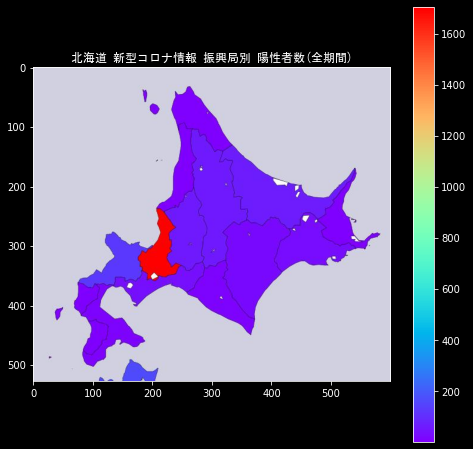

In [17]:
make_hokkaido_heatmap(
    "docs/images/hokkaido-all-n.jpg",
    "北海道 新型コロナ情報 振興局別 陽性者数(全期間)",
    sub_poss.values)

In [18]:
tw_body = "北海道 新型コロナ情報 振興局別 陽性者数[全期間] (北海道 " + today_str + " 時点)"
tweet_with_image(tw, "docs/images/hokkaido-all-n.jpg", tw_body)

In [20]:
dt_last1w = end_date - td(7)
dt_last2w = end_date - td(14)
print(end_date, dt_last1w, dt_last2w)
# 直近1週間
df_last1w = df[df['Date'] > dt_last1w]
sub_last1w = df_last1w.groupby('Code').size()
# 直近2週間
df_last2w = df[df['Date'] > dt_last2w]
sub_last2w = df_last2w.groupby('Code').size()
# 直近1週間陽性者数
sub_pos_last1w = np.zeros(len(sub_prefs))
cnt = 0
for i in sub_last1w.index.to_list():
    sub_pos_last1w[i] = sub_last1w.values[cnt]
    cnt +=1
print(sub_pos_last1w.astype(int))
# 直近2週間陽性者数
sub_pos_last2w = np.zeros(len(sub_prefs))
cnt = 0
for i in sub_last2w.index.to_list():
    sub_pos_last2w[i] = sub_last2w.values[cnt]
    cnt += 1
print(sub_pos_last2w.astype(int))

2020-10-09 00:00:00 2020-10-02 00:00:00 2020-09-25 00:00:00
[ 16 129   0   0   9   6   7   1   0   0   9   3   1   1   0]
[ 23 217   0   0  14   6   7   1   0   1  14   4   3   1   0]


In [26]:
# 計算式は「（直近7日間の新規陽性者数／その前7日間の新規陽性者数）^（平均世代時間／報告間隔）」
agt = 5 # 平均世代時間
ri = 7 #報告間隔
min_smpl = 5 # 最低サンプリング数
Rt = []
for i in np.arange(len(sub_pos_last1w)):
    div = (sub_pos_last2w[i] - sub_pos_last1w[i])
    if div == 0 and sub_pos_last1w[i] > 0:
        Rt.append(1.0) # 0から増加した場合は他地域からの流入
    elif div == 0:
        Rt.append(0.0) # 0を維持
    elif sub_pos_last2w[i] < min_smpl and sub_pos_last1w[i] < min_smpl:
        Rt.append(1) # サンプリングが少ない場合、1 と仮定
    else:
        r = (sub_pos_last1w[i] / div) ** (agt / ri)
        Rt.append(r)
print(Rt)

[1.8048630117397289, 1.3141589114369807, 0.0, 0.0, 1.5217296534183684, 1.0, 1.0, 1.0, 0.0, 1, 1.5217296534183684, 1, 1, 1.0, 0.0]


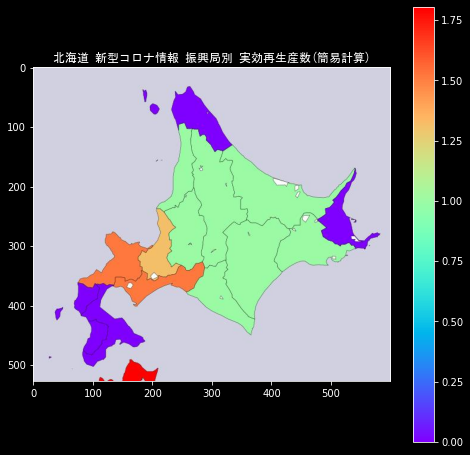

In [27]:
make_hokkaido_heatmap(
    "docs/images/hokkaido-Rt.jpg",
    "北海道 新型コロナ情報 振興局別 実効再生産数(簡易計算)",
    Rt)
tw_body = "北海道 新型コロナ情報 振興局別 実効再生産数[簡易計算] (北海道 " + today_str + " 時点)"
tweet_with_image(tw, "docs/images/hokkaido-Rt.jpg", tw_body)

[2.300000230000023e-06, 9.097365285627923e-05, 0.0, 0.0, 6.917030222481336e-05, 2.108125770783485e-05, 1.4390559792775939e-05, 2.2693232877955795e-05, 0.0, 3.6395797013360898e-06, 3.641584817712669e-05, 6.179992275009656e-05, 8.943690524458013e-06, 4.441325646879081e-06, 0.0]


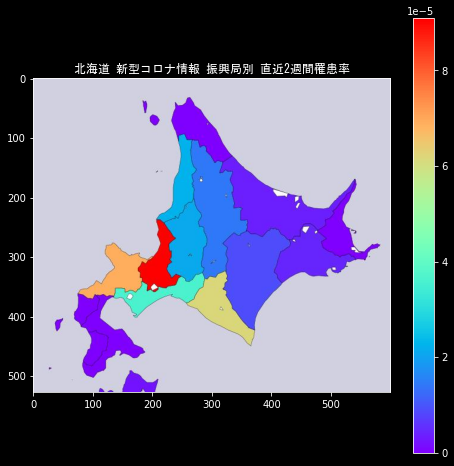

In [23]:
vals = []
for k, v in sub_prefs.items():
    vals.append(sub_pos_last2w[k] / v['total'])
print(vals)
make_hokkaido_heatmap(
    "docs/images/hokkaido-2w.jpg",
    "北海道 新型コロナ情報 振興局別 直近2週間罹患率",
    vals)
tw_body = "北海道 新型コロナ情報 振興局別 直近2週間罹患率 (北海道 " + today_str + " 時点)"
tweet_with_image(tw, "docs/images/hokkaido-2w.jpg", tw_body)